# Coursework Template

**Dependencies and imports**

This can take a minute...

In [ ]:
# !pip install swig
# !pip install --upgrade rldurham

In [ ]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
    
class RunningMeanStd:
    """ Tracks running mean and variance for normalizing inputs. """
    def __init__(self, shape=()):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = 1e-4  # Prevent division by zero

    def update(self, x):
        """ Updates running mean and variance. """
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        
        self.mean, self.var, self.count = self._update_mean_var_count(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)

    def _update_mean_var_count(self, mean, var, count, batch_mean, batch_var, batch_count):
        """ Computes updated mean and variance using Welford's algorithm. """
        delta = batch_mean - mean
        new_count = count + batch_count
        new_mean = mean + delta * batch_count / new_count
        m_a = var * count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * count * batch_count / new_count
        new_var = M2 / new_count
        return new_mean, new_var, new_count

class PPOAgent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=3e-4):
        super(PPOAgent, self).__init__()
        
        # Policy network (Actor)
        self.policy = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )

        # Value network (Critic)
        self.value = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # PPO Hyperparameters
        self.gamma = 0.99        # Discount factor
        self.gae_lambda = 0.97   # GAE smoothing
        self.clip_ratio = 0.2    # PPO clipping range
        self.entropy_coef = 0.01 # Encourages exploration
        self.value_coef = 0.5    # Weight of value loss

        # Action Noise Control
        self.action_std = 0.6
        self.min_action_std = 0.1
        self.action_std_decay = 0.995
        self.noise_decay_start = 100  # Delayed decay

        # Optimizer & Scheduler
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.995)

        # Normalization
        self.state_normalizer = RunningMeanStd(shape=state_dim)
        self.value_normalizer = RunningMeanStd()

        # Experience Storage
        self.trajectory = []
        self.running_rewards = deque(maxlen=100)
        self.episode_count = 0
    
    def normalize_state(self, state):
        """ Normalizes the input state using running mean and variance. """
        state_np = np.array(state, dtype=np.float32)
        return (state_np - self.state_normalizer.mean) / (np.sqrt(self.state_normalizer.var) + 1e-8)

    def sample_action(self, state):
        """ Samples an action from the policy using Gaussian noise. """
        state = torch.FloatTensor(self.normalize_state(state)).unsqueeze(0)
        with torch.no_grad():
            mean_action = self.policy(state).squeeze()
            noise = torch.randn_like(mean_action) * self.action_std
            action = torch.clamp(mean_action + noise, -1, 1)
        return action.numpy()   

    def put_data(self, state, action, reward, next_state, done):
        """ Stores a single experience transition. """
        state = self.normalize_state(state)
        next_state = self.normalize_state(next_state)
        self.trajectory.append((state, action, reward, next_state, done))

    ## ---------------------- PPO Training ---------------------- ##

    def train(self):
        """ Updates policy and value networks using PPO. """
        if len(self.trajectory) < 512:  # Ensure enough data
            return 0, 0
        
        batch = np.array(self.trajectory, dtype=object)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(np.array([self.normalize_state(s) for s in states]))
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array([self.normalize_state(s) for s in next_states]))
        dones = torch.FloatTensor(dones)

        # Compute Value Estimates & Advantages
        with torch.no_grad():
            values = self.value(states).squeeze()
            next_values = self.value(next_states).squeeze()
            advantages, returns = self.compute_advantages(rewards, values, next_values, dones)

        # Compute old log probabilities
        mean_actions = self.policy(states)
        dist = torch.distributions.Normal(mean_actions, self.action_std)
        old_log_probs = dist.log_prob(actions).sum(dim=1)

        # PPO Training Loop
        for _ in range(4):  
            mean_actions = self.policy(states)
            dist = torch.distributions.Normal(mean_actions, self.action_std)
            new_log_probs = dist.log_prob(actions).sum(dim=1)
            entropy = dist.entropy().mean()
            
            # PPO Loss Computation
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            value_pred = self.value(states).squeeze()
            value_loss = nn.functional.mse_loss(value_pred, returns.detach())

            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
            
            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)
            self.optimizer.step()

        # Cleanup & Update Exploration
        self.trajectory.clear()
        if self.episode_count > self.noise_decay_start:
            self.action_std = max(self.min_action_std, self.action_std * self.action_std_decay)
            self.scheduler.step()

        return policy_loss.item(), value_loss.item()

    def compute_advantages(self, rewards, values, next_values, dones):
        """ Computes advantage estimates using Generalized Advantage Estimation (GAE). """
        advantages = torch.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages[t] = gae
        returns = advantages + values
        return (advantages - advantages.mean()) / (advantages.std() + 1e-8), returns

    def get_average_reward(self):
        return np.mean(self.running_rewards) if self.running_rewards else 0
    
    def store_experience(self, batch):
        self.trajectory.extend(batch)
    
    def update_stats(self, reward):
        self.running_rewards.append(reward)
        self.episode_count += 1
    
    def get_avg_reward(self):
        return np.mean(self.running_rewards) if self.running_rewards else 0
    
    def reset(self):
        self.trajectory.clear()
        
    def put_data_batch(self, batch):
        """Store a batch of experience tuples (state, action, reward, next_state, done)."""
        for experience in batch:
            self.trajectory.append(experience)
            
    def get_average_reward(self):
        """Returns the moving average of rewards over the last 100 episodes."""
        return np.mean(self.running_rewards) if self.running_rewards else 0
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition with normalized states"""
        state = self.normalize_state(state)
        next_state = self.normalize_state(next_state)
        self.trajectory.append((state, action, reward, next_state, done))
        
        


**Prepare the environment and wrap it to capture statistics, logs, and videos**

In [ ]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

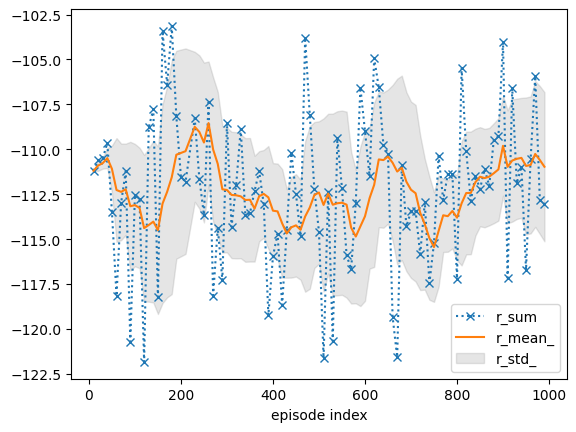

In [16]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = PPOAgent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 1000
max_timesteps = 1000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

for episode in range(max_episodes):
    # Set up episode
    env.info = episode % 10 == 0
    env.video = episode % 10 == 0
    current_observation, info = env.reset()
    episode_reward = 0
    
    # Reset agent's temporal smoothing
    agent.reset()
    
    # Run episode
    for t in range(max_timesteps):
        # Get action from agent
        action = agent.sample_action(current_observation)
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Store transition and update episode reward
        agent.put_data(current_observation, action, reward, next_observation, 
                      terminated or truncated)
        episode_reward += reward
        
        # Update observation
        current_observation = next_observation
        
        # Check if episode is done
        if terminated or truncated:
            break
    
    # Train agent and update statistics
    policy_loss, value_loss = agent.train()
    agent.update_stats(episode_reward)
    
    # Print progress every 10 episodes
    if episode % 10 == 0:
        avg_reward = agent.get_average_reward()
        print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
              f"Avg Reward: {avg_reward:.2f}, "
              f"Action STD: {agent.action_std:.3f}")
    
    # Track and plot
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

env.close()

# Write log file
env.write_log(folder="logs", file="xxxx00-agent-log.txt")

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [17]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
